In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Flatten, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [3]:
temperature = df["T (degC)"].values

In [4]:
raw_data = df.loc[:, "p (mbar)":"wd (deg)"].values

**Data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("Train samples:", num_train_samples)
print("Validation samples:", num_val_samples)
print("Testing samples:", num_test_samples)

Train samples: 210225
Validation samples: 105112
Testing samples: 105114


**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [8]:
train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

### Basic machine-learning model

**Training and evaluating a densely connected model**

In [9]:
inputs = Input(shape=(sequence_length, raw_data.shape[-1]))
x = Flatten()(inputs)
x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
callbacks = [ModelCheckpoint("jena_dense.keras", save_best_only=True)]

In [10]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 10s 8ms/step - loss: 13.1774 - mae: 2.8120 - val_loss: 11.6660 - val_mae: 2.7112
Epoch 2/10
819/819 [==============================] - 7s 8ms/step - loss: 9.4700 - mae: 2.4186 - val_loss: 11.2560 - val_mae: 2.6732
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.6367 - mae: 2.3094 - val_loss: 13.0877 - val_mae: 2.8835
Epoch 4/10
819/819 [==============================] - 7s 8ms/step - loss: 8.1391 - mae: 2.2463 - val_loss: 13.0889 - val_mae: 2.8688
Epoch 5/10
819/819 [==============================] - 7s 8ms/step - loss: 7.8186 - mae: 2.2028 - val_loss: 10.7655 - val_mae: 2.6074
Epoch 6/10
819/819 [==============================] - 7s 8ms/step - loss: 7.5432 - mae: 2.1648 - val_loss: 11.0157 - val_mae: 2.6276
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 7.3366 - mae: 2.1338 - val_loss: 10.7367 - val_mae: 2.6030
Epoch 8/10
819/819 [==============================] - 7s 9ms/step -

In [11]:
model = load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 2s 5ms/step - loss: 11.7022 - mae: 2.6984
Test MAE: 2.70


In [12]:
history.history

{'loss': [13.177441596984863,
  9.469961166381836,
  8.636670112609863,
  8.139066696166992,
  7.818612575531006,
  7.543220520019531,
  7.336594581604004,
  7.167516708374023,
  7.02593469619751,
  6.919934272766113],
 'mae': [2.8119611740112305,
  2.418551206588745,
  2.3094236850738525,
  2.2463104724884033,
  2.2027924060821533,
  2.1647756099700928,
  2.133815288543701,
  2.1082377433776855,
  2.0880813598632812,
  2.0725486278533936],
 'val_loss': [11.665976524353027,
  11.255970001220703,
  13.087733268737793,
  13.088922500610352,
  10.765475273132324,
  11.015718460083008,
  10.736716270446777,
  10.901495933532715,
  12.02987003326416,
  14.3867826461792],
 'val_mae': [2.7111804485321045,
  2.6731960773468018,
  2.883472442626953,
  2.8688175678253174,
  2.6073758602142334,
  2.6275510787963867,
  2.6030256748199463,
  2.6160435676574707,
  2.74006986618042,
  3.036407232284546]}

**Plotting results**

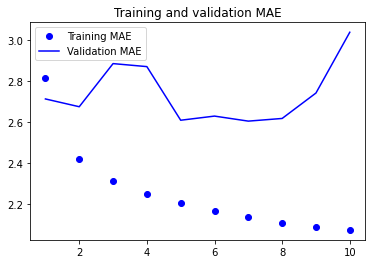

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()